# Business Problem

The goal of this project is to build a Machine Learning model using Naive Bayes that can automatically classify IMDB movie reviews into two categories:

* Positive Sentiment – when the review reflects a favorable opinion about the movie.

* Negative Sentiment – when the review reflects an unfavorable opinion.

In [132]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import string
import matplotlib.pyplot as plt

In [133]:
df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Basic checks

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [135]:
df['Length'] = df['review'].apply(len)

In [136]:
df.head()

,review,sentiment,Length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [137]:
df.describe()

,Length
count,50000.000000
mean,1309.431020
std,989.728014
min,32.000000
25%,699.000000
50%,970.000000
75%,1590.250000
max,13704.000000


## EDA

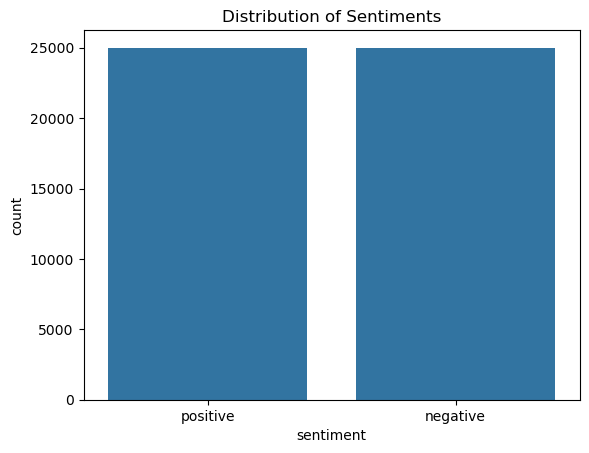

In [138]:
sns.countplot(x='sentiment', data=df)
plt.title("Distribution of Sentiments")
plt.show()

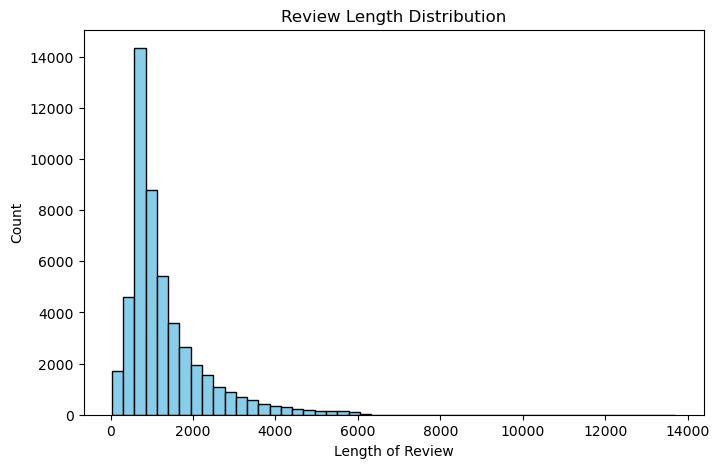

In [139]:
plt.figure(figsize=(8,5))
plt.hist(df['Length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Review Length Distribution")
plt.xlabel("Length of Review")
plt.ylabel("Count")
plt.show()

### EDA Insights
* The dataset is balanced with almost equal positive and negative reviews.  
* Review lengths vary widely, with some very short and some very long.  
* Reviews contain a lot of punctuation and stopwords, which require cleaning.  

# Text Pre-processing

In [140]:
df.loc[df['Length'] == 13704,'review'].iloc[0]

'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

In [141]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [142]:
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})

In [143]:
df.head()

,review,sentiment,Length
0,One of the other reviewers has mentioned that ...,1,1761
1,A wonderful little production. <br /><br />The...,1,998
2,I thought this was a wonderful way to spend ti...,1,926
3,Basically there's a family where a little boy ...,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317


#### 1. Removing Punctuation

In [144]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [145]:
def remove_punct(text):
    myList = []
    for i in text:
        if i not in string.punctuation:
            myList.append(i.lower())
    return "".join(myList)

In [146]:
text = []
for i in df['review']:
    t=remove_punct(i)
    text.append(t)

In [147]:
df['clean_text'] = text

In [148]:
df.head()

,review,sentiment,Length,clean_text
0,One of the other reviewers has mentioned that ...,1,1761,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,998,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,1,926,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,748,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,petter matteis love in the time of money is a ...


In [149]:
df['clean_text'].values

array(['one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with mebr br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordbr br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awaybr br i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt 

In [150]:
df['sentiment'].values

array([1, 1, 1, ..., 0, 0, 0], shape=(50000,))

In [151]:
# splitting X and y
X = df['clean_text'].values
y = df['sentiment'].values

In [152]:
y = y.astype("int")
y

array([1, 1, 1, ..., 0, 0, 0], shape=(50000,))

## Splitting Train and Test Data

In [153]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Text to numerical vectors

# 1. BAG of Words

In [154]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [155]:
cv = CountVectorizer(stop_words="english")

In [156]:
X_train_CV = cv.fit_transform(x_train)

In [157]:
features = cv.get_feature_names_out()

In [ ]:
print(list(features))

### Training a Model

In [159]:
#1. Initialising a bernoulli model
bnb = BernoulliNB()

## fitting the model
bnb.fit(X_train_CV,y_train)

## getting the prediction
y_hat1=bnb.predict(X_test_CV)

## confusion matrix
print(confusion_matrix(y_test,y_hat1))
print(accuracy_score(y_test, y_hat1)*100)

[[4402  559]
 [ 891 4148]]
85.5


In [160]:
#2. Initialising a Multinomial model
NB = MultinomialNB()

In [161]:
NB.fit(X_train_CV,y_train)

MultinomialNB()

In [162]:
# let's apply CV on our test text data
X_test_CV = cv.transform(x_test) 

In [163]:
y_predict = NB.predict(X_test_CV )

In [164]:
# checking accuracy
accuracyscore = accuracy_score(y_test, y_predict)*100
accuracyscore

86.03

In [165]:
# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

In [166]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4961
           1       0.87      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [167]:
print(confusion_matrix(y_test, y_predict))

[[4353  608]
 [ 789 4250]]


# 2. TF-IDF

In [168]:
tf = TfidfVectorizer()

In [169]:
X_train_TF = tf.fit_transform(x_train)
X_test_TF = tf.transform(x_test)

In [170]:
nb = MultinomialNB()

In [171]:
nb.fit(X_train_TF,y_train)

MultinomialNB()

In [172]:
y_hat = nb.predict(X_test_TF)

In [173]:
# Evaluation
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4961
           1       0.89      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [174]:
print(confusion_matrix(y_test,y_hat))

[[4430  531]
 [ 819 4220]]


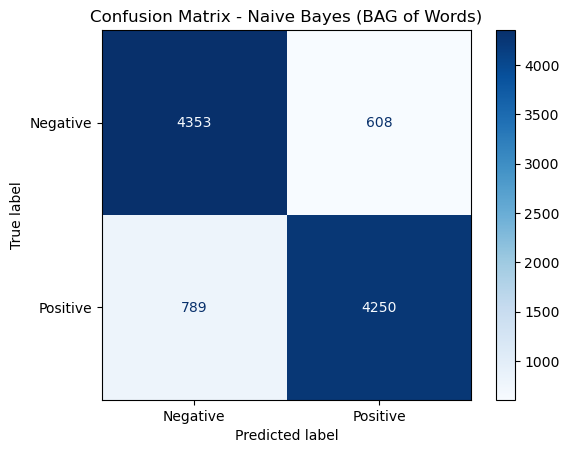

In [177]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (BAG of Words)")
plt.show()

# SentimentClassification Application

In [176]:
#  SentimentClassification Application
msg = input("Enter a movie review: ")
msgInput = tf.transform([msg])
predict = nb.predict(msgInput)

if predict[0] == 0:
    print("Negative Sentiment 😔")
else:
    print("Positive Sentiment 😊")

Enter a movie review:  This is very nice


Positive Sentiment 😊
